In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import numpy as np 
import jVMC
import jax.numpy as jnp
import jax.random as jrnd
import jax
import matplotlib.pyplot as plt
from tqdm import tqdm
import optax
import h5py as h5
import time
import sys
import math
from functools import partial
import bohnasa
# %%
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [2]:
def check_gradient(grad):
    flag = not jnp.all(jnp.isfinite(grad))
    gradR = jnp.where(jnp.isfinite(grad),grad,0)
    return gradR, flag

def re_grad(grad,renormalisation):
    if renormalisation is not None:
        if renormalisation < 0:
            renormalisation = np.min([-renormalisation, np.linalg.norm(grad)])
        grad = renormalisation *grad/np.linalg.norm(grad)
    return grad

def update_optax(psi,psiSampler,H,state_optimizer,optimizer,renormalisation=None):
    success = True
    psi_s, psi_logPsi, psi_p = psiSampler.sample()

    Eloc = H.get_O_loc(psi_s, psi, psi_logPsi)
    Eso = jVMC.util.SampledObs(Eloc, psi_p)
    Emean = Eso.mean()[0]
    Evar = Eso.var()[0]
    Opsi = psi.gradients(psi_s)
    grads = jVMC.util.SampledObs(Opsi, psi_p)
    Egrad = 2.*grads.covar(Eso)
    grad = jnp.real(Egrad)
    grad = jnp.nan_to_num(grad,0.)
    n_grad = jnp.linalg.norm(grad)
    grad = re_grad(grad,renormalisation)
    checked_grad, flag = check_gradient(grad)
    
    psi_params = psi.get_parameters()
    n_p = jnp.linalg.norm(psi_params)
    if flag:
        success = False
        print("checking grad failed:")
        print("checked grad",checked_grad)
        print("grad",grad)
        return Emean.real,Evar,state_optimizer,n_p, n_grad, success

    update, state_optimizer = optimizer.update(
        checked_grad.reshape(psi_params.shape), state_optimizer, psi_params  # type: ignore
    )
    
    params = optax.apply_updates(psi_params, update)  # type: ignore
    
    psi.set_parameters(params)
    return Emean.real,Evar,state_optimizer,n_p, n_grad,success
def sr_update(psi,lr_SR,equations,H,renormalisation=None,repeats=10):
    success = True
    dpOld = psi.get_parameters()            
    n_p = jnp.linalg.norm(dpOld)
    dp    = equations(dpOld,0,hamiltonian=H, psi=psi,intStep=0)
    dp = jnp.nan_to_num(dp,0.)
    #for i in range(repeats):
    #    dp_add  = equations(dpOld,0,hamiltonian=H, psi=psi,intStep=0)
    #    dp += jnp.nan_to_num(dp_add,0.)
    #dp /= repeats
    n_grad = jnp.linalg.norm(dp)

    dp = re_grad(dp,renormalisation)
    if n_grad > (100* n_p):
        success = False
        print("norm of gradient exceeded 100 times the parameter norm\ntraining step not accepted")
        return jnp.real(equations.ElocMean0) , equations.ElocVar0, n_p, n_grad,success

    #dp, _ = stepperSR.step(0, equations, dpOld, hamiltonian=H, psi=psi)
    psi.set_parameters(dpOld + lr_SR * jnp.real(dp))
    return  jnp.real(equations.ElocMean0) , equations.ElocVar0, n_p, n_grad,success


In [3]:
L = 40 #int(sys.argv[1])
N = L//4
ldim = N+1

numSamp = np.min([2**8, math.comb(N+L-1,L-1)-3])
print(numSamp)

homFock = jnp.ones((1,1,L),dtype=int)
oneSiteFockStates = jnp.expand_dims(jnp.eye(L,dtype=int)*N,0)
J = 1
U = 10.#0.25

seedMu = 100
folder = "data/"
name = f"obc_N{N}_L{L}_ldim{ldim}_J{J:.3f}_U{U:.3f}_numSam{numSamp}"

keyMu = jrnd.PRNGKey(seedMu)
mu = 0.* jnp.flip(-0.12*jrnd.normal(keyMu,(L,)))
H = jVMC.operator.bosons.BoseHubbard_Hamiltonian1D(L,J,U,mu=mu,lDim=ldim,)



256


In [4]:
parameterGPT_not_pached = {
            "L": L,
            "LocalHilDim": ldim,
            "embeddingDim": 8,
            "depth" : 2,
            "nHeads" : 2,
            "hiddenDim": 8,
}
parameterGPT= {
            "L": L,
            "LHilDim": ldim,
            "embeddingDim": 8,
            "patch_size": 2,
            "depth" : 2,
            "nHeads" : 2,
            "hiddenDim": 8,
}


In [5]:
if math.comb(N+L-1,L-1)<2e5:
    fock = bohnasa.fockStates_fixed_particle_number(N,L)
    hopping = bohnasa.hopping(fock,connections='obc')
    hopping.matrix *= -J
    interaction = bohnasa.interaction(fock)
    interaction.matrix *= U/2
    chemical = bohnasa.chemical_mu(fock,np.array(mu))

    H_ed = hopping + interaction + chemical
    ev, es = np.linalg.eigh(H_ed.matrix.todense())
    print(ev[0])
    maxOv = np.argmax(np.abs(es[:,0]))
    fock.fockArray[maxOv], es[maxOv,0]
else:
    ev = np.array([np.nan,np.nan])
    es = np.array([ev]*len(ev))
print(ev,es.shape)

[nan nan] (2, 2)


In [6]:


netGPT_patched = jVMC.nets.bosons.GPT_patched(**parameterGPT)
netGPT = jVMC.nets.bosons.gpt_stupid.GPT(**parameterGPT_not_pached)
seed = 1
key2 = jrnd.PRNGKey(seed)

par_netGPT_patched = jVMC.nets.particle_conservation_patched(netGPT_patched,N)
par_netGPT = jVMC.nets.particle_conservation(netGPT,N)

sym= jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")


sym_par_netGPT_patched = jVMC.nets.sym_wrapper.SymNet(sym,par_netGPT_patched,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)
sym_par_netGPT = jVMC.nets.sym_wrapper.SymNet(sym,par_netGPT,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)


batSize = 2**4
psi_sym_par_netGPT_patched = jVMC.vqs.NQS(sym_par_netGPT_patched,batchSize=batSize)
psi_sym_par_netGPT = jVMC.vqs.NQS(sym_par_netGPT,batchSize=batSize)


In [7]:

key = jrnd.PRNGKey(1)
nS = 2**7
sampler_GPT_patched = jVMC.sampler.MCSampler(psi_sym_par_netGPT_patched,(L,),key,numSamples=nS)
sampler_GPT = jVMC.sampler.MCSampler(psi_sym_par_netGPT,(L,),key,numSamples=nS)



In [8]:
%%timeit
sampler_GPT.sample()

110 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:

%%timeit
sampler_GPT_patched.sample()

60.3 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
diagonalShift = 1e-4
diagonalMulti = 1e-4

minSR_equationGPT_patched = jVMC.util.MinSR(sampler_GPT_patched, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti)
minSR_equationGPT = jVMC.util.MinSR(sampler_GPT, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti)

#stepperSR = jVMC.util.stepper.Euler(timeStep=lr_SR)  

# %%
training_steps= 2000
resTrainingGPT = np.zeros((training_steps,5))
resTrainingGPT_patched = np.zeros((training_steps,5))

windowADAM = np.zeros(training_steps,dtype=bool)

windowADAM[:300] = True


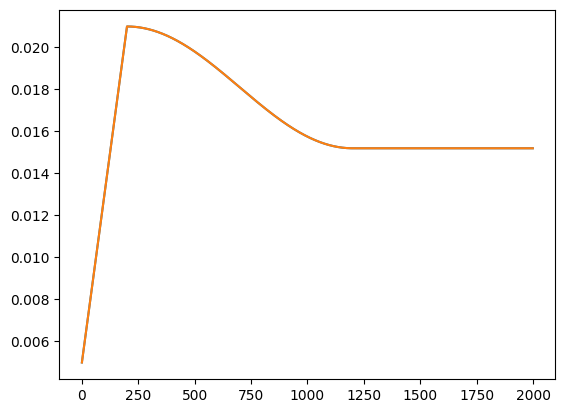

In [11]:
lr_ADAM = optax.linear_schedule(init_value=0.02, end_value=0.001, transition_steps=100)
lr_ADAM = optax.linear_schedule(init_value=0.02, end_value=0.001, transition_steps=100)
lr_ADAM = optax.cosine_onecycle_schedule(training_steps, peak_value=.1, pct_start = 0.01, div_factor = 25.0, final_div_factor = 10000.0)
lr_ADAM = optax.warmup_cosine_decay_schedule(0.005,0.021,warmup_steps=200,decay_steps=1200,end_value=0.0152)
plt.plot([lr_ADAM(i) for i in range(training_steps)])
plt.plot(lr_ADAM(np.arange(training_steps)))
#lr_ADAM(training_steps)


In [12]:

optimizer = optax.noisy_sgd
opt_hyp = optax.inject_hyperparams(optimizer)(learning_rate=lr_ADAM,eta=0.13,gamma=0.1)
stateOpt_GPT = opt_hyp.init(psi_sym_par_netGPT.get_parameters()) 
stateOpt_GPT_patched = opt_hyp.init(psi_sym_par_netGPT_patched.get_parameters()) 

renormalisation = None

In [13]:
pbar = tqdm(range(training_steps))

for n,p in enumerate(pbar):
    if windowADAM[n]:
        pbar.set_description("adam training")
    else:
        pbar.set_description("SR training")

    ticGPT = time.perf_counter()
    if windowADAM[n]:
        Emean,Evar,stateOpt_GPT,n_p,n_p_grad, success = update_optax(psi_sym_par_netGPT,sampler_GPT,H,stateOpt_GPT,opt_hyp,renormalisation=renormalisation)
    else:
        Emean,Evar,n_p,n_p_grad,success  = sr_update(psi_sym_par_netGPT,lr_ADAM(n),minSR_equationGPT,H,renormalisation=renormalisation)
    tocGPT = time.perf_counter()

    resTrainingGPT[n] = [Emean,Evar,n_p,n_p_grad,tocGPT-ticGPT]

    postfix = {"E_GPT": resTrainingGPT[n,0], 
               "var E_GPT": resTrainingGPT[n,1], 
               }
    pbar.set_postfix(postfix)
    


adam training:   0%|          | 0/2000 [00:00<?, ?it/s]

SR training: 100%|██████████| 2000/2000 [59:31<00:00,  1.79s/it, E_GPT=-20, var E_GPT=0.0039]   


In [14]:

optimizer = optax.noisy_sgd
opt_hyp = optax.inject_hyperparams(optimizer)(learning_rate=lr_ADAM,eta=0.13,gamma=0.1)
stateOpt_GPT = opt_hyp.init(psi_sym_par_netGPT.get_parameters()) 
stateOpt_GPT_patched = opt_hyp.init(psi_sym_par_netGPT_patched.get_parameters()) 

renormalisation = None

In [15]:
pbar = tqdm(range(training_steps))

for n,p in enumerate(pbar):
    if windowADAM[n]:
        pbar.set_description("adam training")
    else:
        pbar.set_description("SR training")

    ticGPT = time.perf_counter()
    if windowADAM[n]:
        Emean,Evar,stateOpt_GPT_patched,n_p,n_p_grad, success = update_optax(psi_sym_par_netGPT_patched,sampler_GPT_patched,H,stateOpt_GPT_patched,opt_hyp,renormalisation=renormalisation)
    else:
        Emean,Evar,n_p,n_p_grad,success  = sr_update(psi_sym_par_netGPT_patched,lr_ADAM(n),minSR_equationGPT_patched,H,renormalisation=renormalisation)
    tocGPT = time.perf_counter()

    resTrainingGPT_patched[n] = [Emean,Evar,n_p,n_p_grad,tocGPT-ticGPT]

    postfix = {"E_GPT": resTrainingGPT_patched[n,0], 
               "var E_GPT": resTrainingGPT_patched[n,1], 
               }
    pbar.set_postfix(postfix)

SR training: 100%|██████████| 2000/2000 [39:38<00:00,  1.19s/it, E_GPT=-20, var E_GPT=0.00334]  


parameters GPT: 1889
parameters GPT patched: 3979


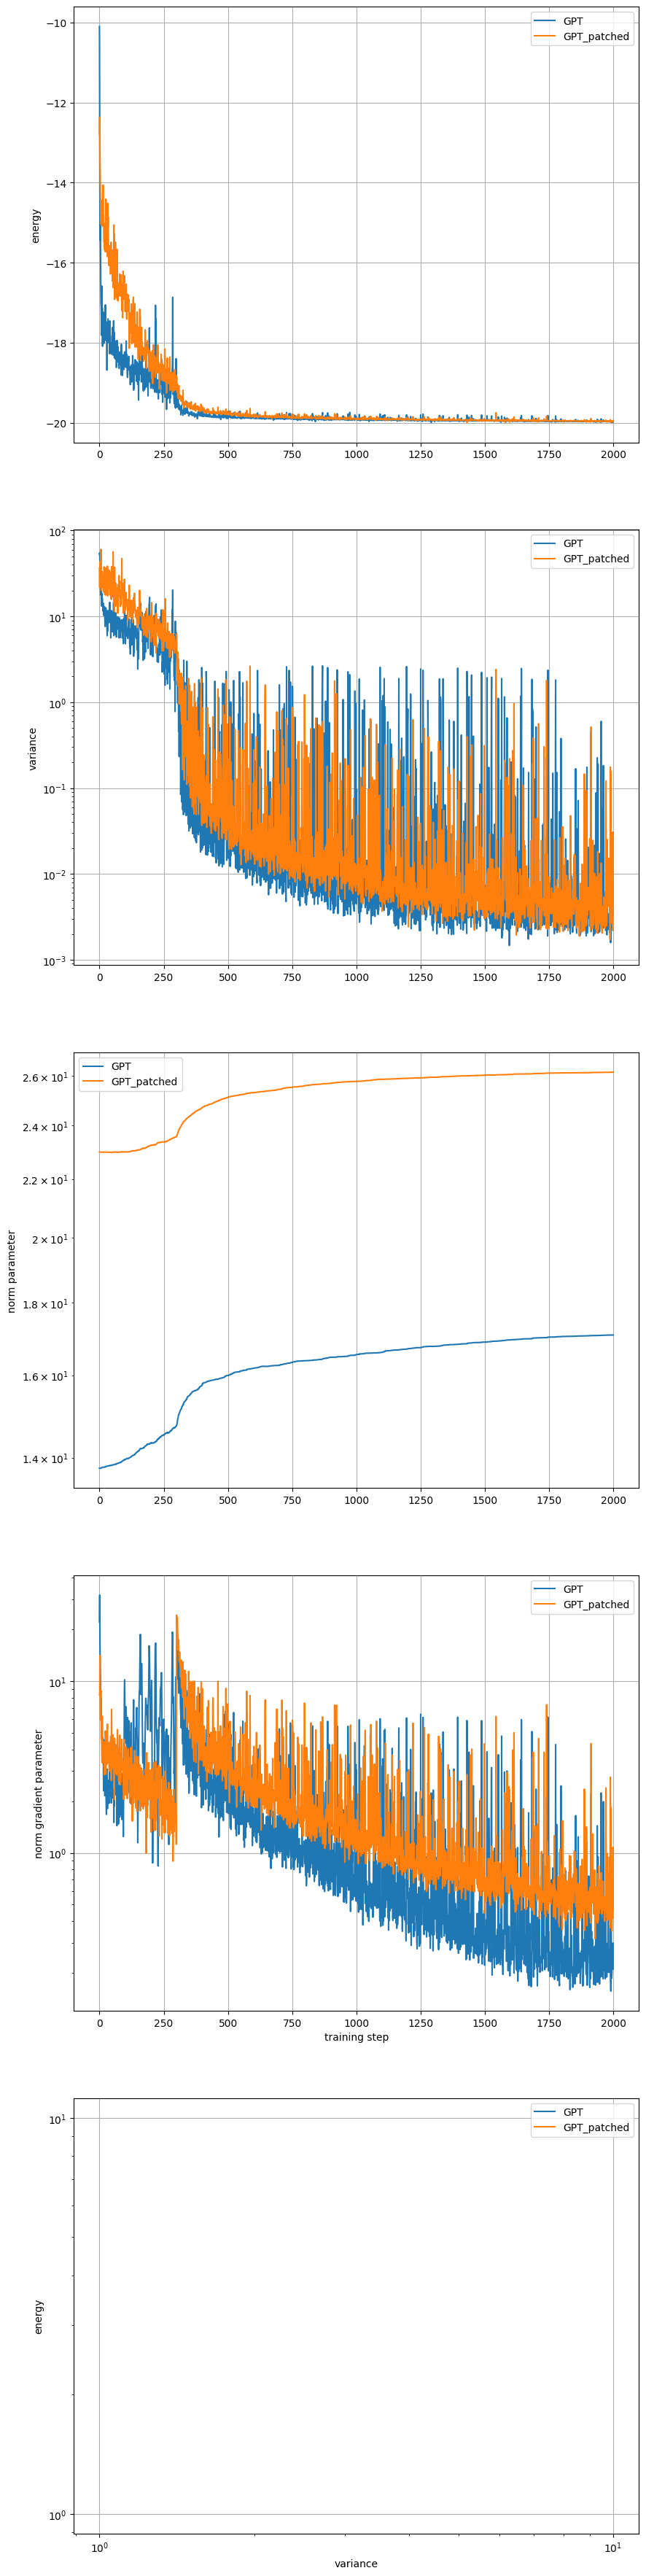

In [16]:
# %%
fig,ax = plt.subplots(5,figsize=(10,45))
ax[0].plot(resTrainingGPT[:,0],label="GPT")
ax[0].plot(resTrainingGPT_patched[:,0],label="GPT_patched")
ax[0].set_ylabel("energy")
ax[0].legend()
ax[0].grid()
ax[1].plot(resTrainingGPT[:,1],label="GPT")
ax[1].semilogy(resTrainingGPT_patched[:,1],label="GPT_patched")
ax[1].set_ylabel("variance")
ax[1].legend()
ax[1].grid()
ax[2].plot(resTrainingGPT[:,2],label="GPT")
ax[2].semilogy(resTrainingGPT_patched[:,2],label="GPT_patched")
ax[2].set_ylabel("norm parameter")
ax[2].grid()
ax[2].legend()
ax[3].plot(resTrainingGPT[:,3],label="GPT")
ax[3].semilogy(resTrainingGPT_patched[:,3],label="GPT_patched")
ax[3].set_xlabel("training step")
ax[3].grid()
ax[3].set_ylabel("norm gradient parameter")

ax[3].legend()

emin = ev[0]
ax[4].loglog(resTrainingGPT[:,1],np.abs(emin-resTrainingGPT[:,0]),label="GPT")
ax[4].loglog(resTrainingGPT_patched[:,1],np.abs(emin-resTrainingGPT_patched[:,0]),label="GPT_patched")
ax[4].legend()
ax[4].set_ylabel("energy")
ax[4].set_xlabel("variance")
ax[4].grid()

print("parameters GPT:", len(psi_sym_par_netGPT.get_parameters()))
print("parameters GPT patched:", len(psi_sym_par_netGPT_patched.get_parameters()))

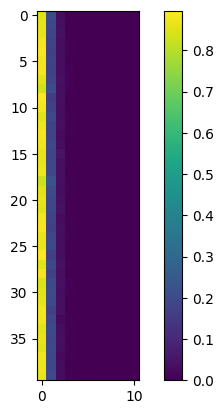

In [17]:

plt.imshow(np.array([np.histogram(x,ldim,range=(0,ldim-1),density=True)[0] for x in  sampler_GPT.sample(numSamples=1000)[0][0].T]))
plt.colorbar()


In [18]:

plt.imshow(np.array([np.histogram(x,ldim,range=(0,ldim-1),density=True)[0] for x in  sampler_RWKV.sample(numSamples=1000)[0][0].T]))
plt.colorbar()
mu

NameError: name 'sampler_RWKV' is not defined

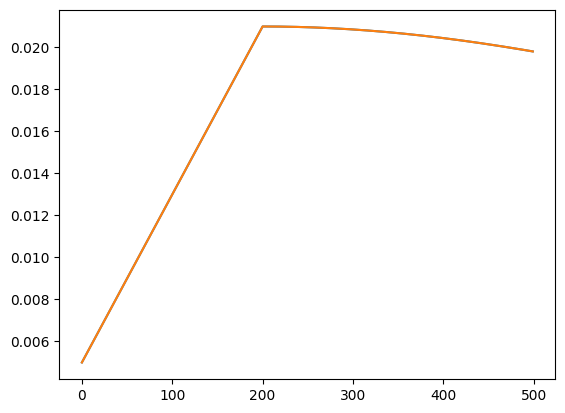

In [15]:
lr_ADAM = optax.linear_schedule(init_value=0.02, end_value=0.001, transition_steps=100)
lr_ADAM = optax.linear_schedule(init_value=0.02, end_value=0.001, transition_steps=100)
lr_ADAM = optax.cosine_onecycle_schedule(training_steps, peak_value=.1, pct_start = 0.01, div_factor = 25.0, final_div_factor = 10000.0)
lr_ADAM = optax.warmup_cosine_decay_schedule(0.005,0.021,warmup_steps=200,decay_steps=1200,end_value=0.0152)
plt.plot([lr_ADAM(i) for i in range(training_steps)])
plt.plot(lr_ADAM(np.arange(training_steps)))
#lr_ADAM(training_steps)

In [16]:


optimizer = optax.noisy_sgd
optAdam_GPT = optax.inject_hyperparams(optimizer)(learning_rate=lr_ADAM,eta=0.13,gamma=0.1)
stateAdam_GPT = optAdam_GPT.init(psi_GPT.get_parameters()) 
minSR_equation_GPT = jVMC.util.MinSR(sampler_GPT, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti,pinvTol=1e-14)

optAdam_RWKV = optax.inject_hyperparams(optimizer)(learning_rate=lr_ADAM,eta=0.13,gamma=0.1)
stateAdam_RWKV = optAdam_RWKV.init(psi_RWKV.get_parameters()) 
minSR_equation_RWKV = jVMC.util.MinSR(sampler_RWKV, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti,pinvTol=1e-14)

renormalisation = None

nameGPT = folder + optimizer.__name__ + "_" + "GPT_" + name+f"_netpara_dep{dep}_emb{ebDim}_nH{nH}"

nameRWKV = folder + optimizer.__name__ + "_" +"RWKV_" +name+ f"_netpara_dep{depth_RWKV}_emb{emb_RWKV}_hid{hidden_size}_nH{num_heads}"


# %%
h5saveGPT = jVMC.util.h5SaveParams(nameGPT.replace('.','-')+".hdf5",'w')
h5saveRWKV = jVMC.util.h5SaveParams(nameRWKV.replace('.','-')+".hdf5",'w')


In [17]:
pbar = tqdm(range(training_steps))

for n,p in enumerate(pbar):
    if windowADAM[n]:
        pbar.set_description("adam training")
    else:
        pbar.set_description("SR training")

    ticGPT = time.perf_counter()
    if windowADAM[n]:

        Emean,Evar,stateAdam_GPT,n_p,n_p_grad, success = update_optax(psi_GPT,sampler_GPT,H,stateAdam_GPT,optAdam_GPT,renormalisation=renormalisation)
    else:
        #Emean,Evar = sr_update_old(psi,stepperSR,minSR_equation,H)
        Emean,Evar,n_p,n_p_grad,success  = sr_update(psi_GPT,lr_ADAM(n),minSR_equation_GPT,H,renormalisation=renormalisation)
    tocGPT = time.perf_counter()
    #print(Emean,Evar)
    resTrainingGPT[n] = [Emean,Evar,n_p,n_p_grad,tocGPT-ticGPT]
    #progressRange.set_postfix(energy=f"{Emean:.2f}", variance = f" {Evar:.2e}", norm_p=f"{n_p:.2f}",norm_p_grad=f"{n_p_grad:.2f}")
    ticRWKV = time.perf_counter()
    if windowADAM[n]:
        Emean,Evar,stateAdam_RWKV,n_p,n_p_grad,success = update_optax(psi_RWKV,sampler_RWKV,H,stateAdam_RWKV,optAdam_RWKV,renormalisation=renormalisation)
    else:
        #Emean,Evar = sr_update_old(psi,stepperSR,minSR_equation,H)
        Emean,Evar,n_p,n_p_grad,success  = sr_update(psi_RWKV,lr_ADAM(n),minSR_equation_RWKV,H,renormalisation=renormalisation)
    
    if success == False:
        pass
    tocRWKV = time.perf_counter()
    resTrainingRWKV[n] = [Emean,Evar,n_p,n_p_grad,tocRWKV-ticRWKV]
    if (((n%10)==0 ) or (n == (training_steps-1))):
        h5saveRWKV.save_model_params(psi_RWKV.parameters,
                                                f"training_step_{n}",
                                                {"Emean" :resTrainingRWKV[n,0],
                                                "Evar" :resTrainingRWKV[n,1],
                                                "norm_parameter" :resTrainingRWKV[n,2],
                                                "norm_gradient" :resTrainingRWKV[n,3],
                                                "time" : tocRWKV-ticRWKV
                                                })
        h5saveGPT.save_model_params(psi_GPT.parameters,
                                                f"training_step_{n}",
                                                {"Emean" :resTrainingGPT[n,0],
                                                "Evar" :resTrainingGPT[n,1],
                                                "norm_parameter" :resTrainingGPT[n,2],
                                                "norm_gradient" :resTrainingGPT[n,3],
                                                "time" : tocGPT-ticGPT
                                                })
                                                #{"infidelity": infidelities[i],
                                                #"time":T,
                                                #"psi_obs":psi_obs,
                                                #"psi_var":psi_var,
                                                #"chi_obs":chi_obs,
                                                #"chi_var":chi_var,
                                                #"lr":learning_rate,
                                                #"dshift":d_shift,
                                                #"seed":seed,
                                                #"numSamples":numSamples,
                                                #"net_size":psi_params.shape[0],
                                                #"net":config["net"]})
    postfix = {"E_GPT": resTrainingGPT[n,0], 
               "E_RWKV": resTrainingRWKV[n,0], 
               "var E_GPT": resTrainingGPT[n,1], 
               "var E_RWKV": resTrainingRWKV[n,1], 
               }
    pbar.set_postfix(postfix)


    h5saveGPT.save_model_params({"mean" : resTrainingGPT[:,0], "var" : resTrainingGPT[:,1]},"energy_training",{})
    h5saveGPT.save_model_params({"norm" : resTrainingGPT[:,2], "grad norm" : resTrainingGPT[:,3]},"norm_parameter",{})
    h5saveGPT.save_model_params({"total_time" : resTrainingGPT[:,4]},"timing",{})

    h5saveRWKV.save_model_params({"mean" : resTrainingRWKV[:,0], "var" : resTrainingRWKV[:,1]},"energy_training",{})
    h5saveRWKV.save_model_params({"norm" : resTrainingRWKV[:,2], "grad norm" : resTrainingRWKV[:,3]},"norm_parameter",{})
    h5saveRWKV.save_model_params({"total_time" : resTrainingRWKV[:,4]},"timing",{})



adam training:   0%|          | 0/500 [00:00<?, ?it/s]

adam training: 100%|██████████| 500/500 [05:20<00:00,  1.56it/s, E_GPT=-.57, E_RWKV=-.561, var E_GPT=0.343, var E_RWKV=0.0987] 


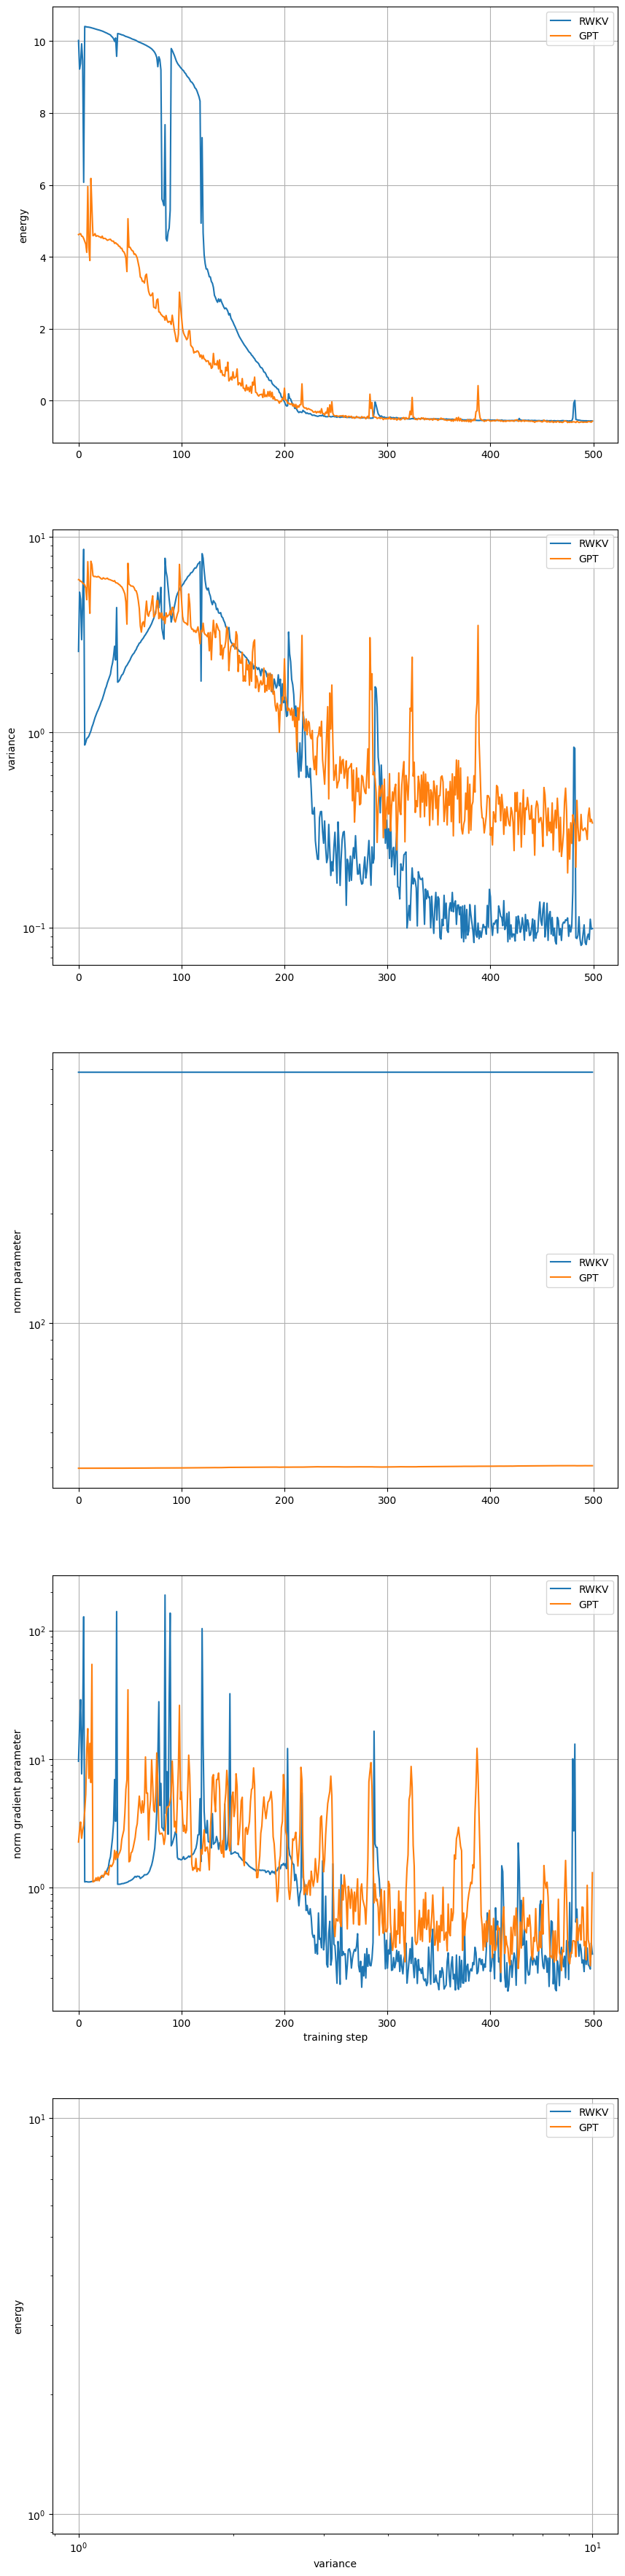

In [18]:
h5saveRWKV.save_model_params({"adam" : windowADAM},"training",{"default": "SR", "lr_SR" : lr_SR,"lr_ADAM" : lr_ADAM(np.arange(training_steps))})


# %%
fig,ax = plt.subplots(5,figsize=(10,45))
ax[0].plot(resTrainingRWKV[:,0],label="RWKV")
ax[0].plot(resTrainingGPT[:,0],label="GPT")
ax[0].set_ylabel("energy")
ax[0].legend()
ax[0].grid()
ax[1].plot(resTrainingRWKV[:,1],label="RWKV")
ax[1].semilogy(resTrainingGPT[:,1],label="GPT")
ax[1].set_ylabel("variance")
ax[1].legend()
ax[1].grid()
ax[2].plot(resTrainingRWKV[:,2],label="RWKV")
ax[2].semilogy(resTrainingGPT[:,2],label="GPT")
ax[2].set_ylabel("norm parameter")
ax[2].grid()
ax[2].legend()
ax[3].plot(resTrainingRWKV[:,3],label="RWKV")
ax[3].semilogy(resTrainingGPT[:,3],label="GPT")
ax[3].set_xlabel("training step")
ax[3].grid()
ax[3].set_ylabel("norm gradient parameter")

ax[3].legend()

emin = ev[0]
ax[4].loglog(resTrainingRWKV[:,1],np.abs(emin-resTrainingRWKV[:,0]),label="RWKV")
ax[4].loglog(resTrainingGPT[:,1],np.abs(emin-resTrainingGPT[:,0]),label="GPT")
ax[4].legend()
ax[4].set_ylabel("energy")
ax[4].set_xlabel("variance")
ax[4].grid()


nameFIG = folder + "plot_difference_" +name
nameFIG += f"_RWKVpara_dep{depth_RWKV}_emb{emb_RWKV}_hid{hidden_size}_nH{num_heads}"

nameFIG += f"_GPTpara_dep{dep}_emb{ebDim}_nH{nH}"
plt.savefig(nameFIG+".pdf")


In [19]:
sampler_GPT.sample(numSamples=20)

(Array([[[2, 5, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 2, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 1, 1, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 1, 1, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 1, 3, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [3, 2, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      

In [20]:
sampler_RWKV.sample(numSamples=20)

(Array([[[2, 1, 1, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 1, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 1, 3, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 2, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 1, 2, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 2, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      

In [21]:
numSamp,fock.dim

NameError: name 'fock' is not defined

146.34216553901288

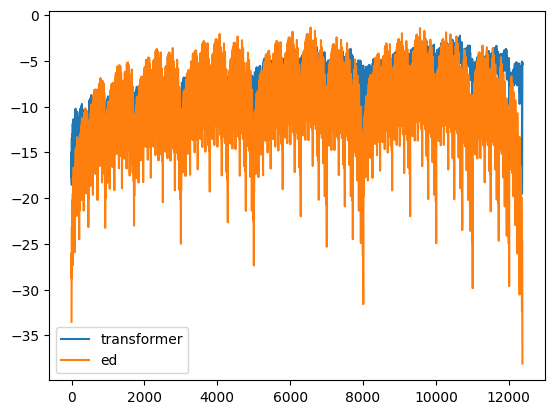

In [22]:
plt.plot(psi_GPT(jnp.array([fock.fockArray]))[0],label="transformer")
#plt.plot(psi_RWKV(jnp.array([fock.fockArray]))[0])
plt.plot(np.log(np.abs(es[:,0])),label="ed")
plt.legend()
np.linalg.norm(np.exp(psi_GPT(jnp.array([fock.fockArray]))[0]) -(np.abs(es[:,0])))

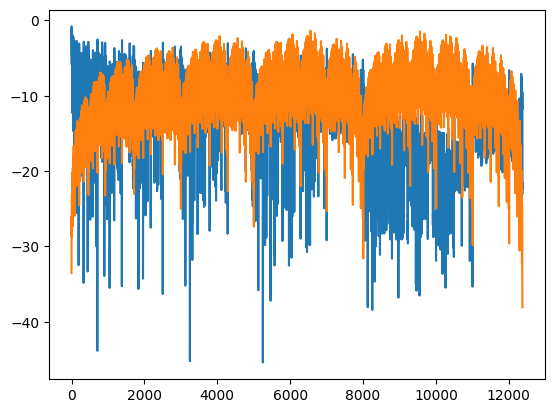

In [23]:
#plt.plot(psi_GPT(jnp.array([fock.fockArray]))[0])
plt.plot(psi_RWKV(jnp.array([fock.fockArray]))[0])
plt.plot(np.log(np.abs(es[:,0])))
